# Bit-flip code

In this notebook, I am going to implement the bit-flip error-detecting and error-correcting code via *qiskit* library. 

## I. Introduction of Background Knowledge
The bit-flip noise here is a single qubit noise and the corresponding noise channel is given by
\begin{equation}
\mathcal{N}(\rho) = (1-p)\mathbf{I}\rho + p \mathbf{X}\rho \mathbf{X}
\end{equation}

Usually, we are only interested in correction of one qubit with arbitrary quantum state. In classical error correcting procedure, it is ususally to encode 1 bit information into 3 bits, and the bit-flip noise will flip one of three bits in general. By looking at the other two bits, we can recovery the bit flip noise. Similarly, in quantum computation, we can also do the similar encoding and
\begin{equation}
|0_L\rangle = |000\rangle, |1_L\rangle = |111\rangle. 
\end{equation}
People call this the **repetition code** and it is a very useful model to correct the bit-flip and phase-flip error. For one target quantum state $|\psi\rangle = a|0\rangle + b|1\rangle$, the bit-flip error correction will follow the procedure below:
* Encode $|\psi\rangle$ into repetition form, $|\psi_L\rangle=a|000\rangle+b|111\rangle$
* (Noise happen)
* Specify the noise with the help of syndrome from stabilizer. 
* Recover the noise with syndrome measurement result
* Decode $|\psi_L\rangle$ and re-generate $|\psi\rangle = a|0\rangle + b|1\rangle$

In the following sections, I will provide details of each steps and construct the corresponding circuit. 

In [1]:
# Import require package
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, Aer, IBMQ
from qiskit.visualization import plot_histogram
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

## II. The Procedure of Bit-Flip Noise Correction
In this section, I will describe details of how to finish 5 steps of bit-flip noise correction. 

### A. Encoding
The encoding process that transfer $|\psi\rangle=a|0\rangle+b|1\rangle$ into repetition form, $|\psi_L\rangle = a|000\rangle + b|111\rangle$ is shown below. We use the CNOT gate to generate the entangled state $|\psi_L\rangle$. The two ancilla qubits will be used to detect error in the future. 

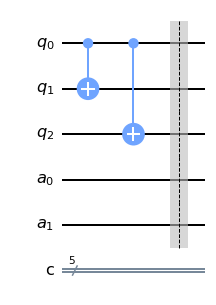

In [2]:
# Construct quantum circuit
qreg_q = QuantumRegister(3, 'q')
qreg_a = QuantumRegister(2, 'a')
creg_c = ClassicalRegister(5, 'c')
circuit = QuantumCircuit(qreg_q, qreg_a, creg_c)

# Encoding
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.barrier()
circuit.draw()

### B. Error Detection
In the bit-flip noise case, we consider three kinds of single-qubit error, $XII$, $IXI$ and $IIX$. We need to specify which error happens and thus perform the corresponding recovery. The stabilizer code formulism will be helpful to build the detection code and specify error with syndrome. The stabilizer of bit-flip code is 
\begin{equation}
\mathcal{S} = \{ ZZI,IZZ\}.
\end{equation}
The corresponding syndrome for different error types is given by

| Error  |  $S_1$  | $S_2$     |
| :----:       |   :----:  |  :----: |
| No Error   |  +1       | +1   |
|  $XII$   | -1      | +1     |
|  $IXI$  | -1      | -1     |
|  $IIX$  | +1      | -1     |

One can construct the error detecting circuit with the table above. Note that in practice, CNOT gate is used to detect the eigenvalue of $Z$ operation, and the following gate would be used to detect the eigenvalue of $X$ operation. 

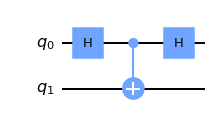

In [3]:
# Detect eigenvalue of X
tmp = QuantumCircuit(2)
tmp.h(0)
tmp.cx(0,1)
tmp.h(0)
tmp.draw()

Bit-flip correcting code requires two stabilizers, $ZZI$ and $IZZ$, thus the error detecting circuit can be constructed as follow. Note that the error detecting code would not break the coherence of $|\psi_L\rangle=a|000\rangle+b|111\rangle$ while detecting the error, since the stabilizer $\mathcal{S}_i E_{a}|\psi_L\rangle=\pm |\psi_L\rangle $ and all operations in the detection circuit is $\mathcal{S}_i$ operation on the circuit. Note also that the resulting state of ancilla qubits are either $|0\rangle$ or $|1\rangle$, corresponding to the eigenvalue $+1$ and $-1$. 

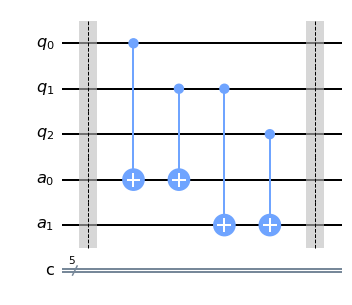

In [4]:
# Construct quantum circuit
qreg_q = QuantumRegister(3, 'q')
qreg_a = QuantumRegister(2, 'a')
creg_c = ClassicalRegister(5, 'c')
circuit = QuantumCircuit(qreg_q, qreg_a, creg_c)

# Error Detection Circuit
circuit.barrier()
circuit.cx(qreg_q[0], qreg_a[0])
circuit.cx(qreg_q[1], qreg_a[0])
circuit.cx(qreg_q[1], qreg_a[1])
circuit.cx(qreg_q[2], qreg_a[1])
circuit.barrier()
circuit.draw()

### C. Recover the Noise
According to the table of syndrome, we can construct a recovery circuit to correct one of three possible error. In practice, a CNOT gate is used to detect the $-1$ eigenvalue (or $|1\rangle$) state, and the Toffoli gate (or other advanced multi-control gates) is used to detect and correct, e.g., $IXI$ error. The recovery circuit is shown below.

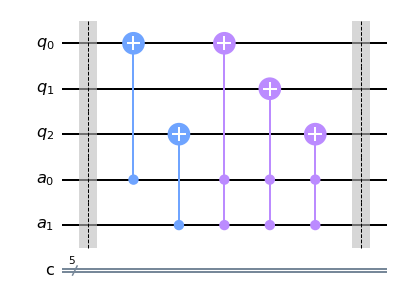

In [5]:
# Construct quantum circuit
qreg_q = QuantumRegister(3, 'q')
qreg_a = QuantumRegister(2, 'a')
creg_c = ClassicalRegister(5, 'c')
circuit = QuantumCircuit(qreg_q, qreg_a, creg_c)

# Recovery
circuit.barrier()
circuit.cx(qreg_a[0], qreg_q[0])
circuit.cx(qreg_a[1], qreg_q[2])
circuit.ccx(qreg_a[0], qreg_a[1], qreg_q[0])
circuit.ccx(qreg_a[0], qreg_a[1], qreg_q[1])
circuit.ccx(qreg_a[0], qreg_a[1], qreg_q[2])
circuit.barrier()
circuit.draw()

### D. Decoding the Resulting State
Remember that we encode 1 qubit information into a 3-qubits state to protect it from the bit-flip error, thus we need to recover the initial input state, or decode the resulting state. The decoding process is simply the inverse of encoding process, namely,

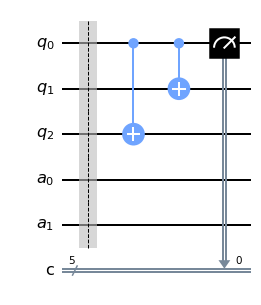

In [6]:
# Construct quantum circuit
qreg_q = QuantumRegister(3, 'q')
qreg_a = QuantumRegister(2, 'a')
creg_c = ClassicalRegister(5, 'c')
circuit = QuantumCircuit(qreg_q, qreg_a, creg_c)

# Decoding
circuit.barrier()
circuit.cx(qreg_q[0], qreg_q[2])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.measure(qreg_q[0], creg_c[0])
circuit.draw()

## III. Test the Method
With detail description in each subsection, in this part, I combine 5 steps together and construct a complete circuit,

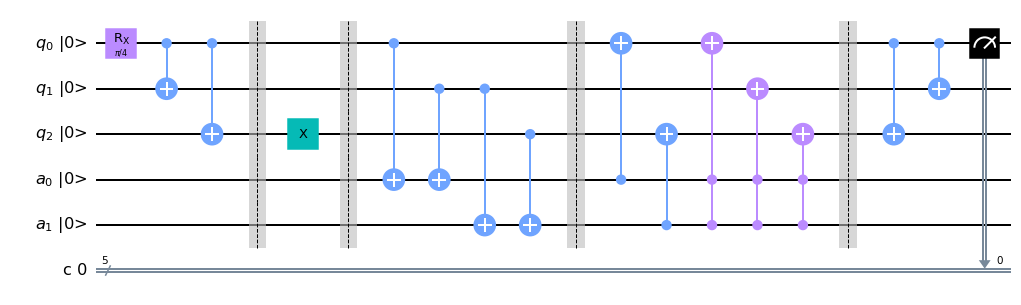

In [7]:
qreg_q = QuantumRegister(3, 'q')
qreg_a = QuantumRegister(2, 'a')
creg_c = ClassicalRegister(5, 'c')
circuit = QuantumCircuit(qreg_q, qreg_a, creg_c)

circuit.rx(np.pi/4, 0)

circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.barrier()
circuit.x(qreg_q[2])
circuit.barrier()
circuit.cx(qreg_q[0], qreg_a[0])
circuit.cx(qreg_q[1], qreg_a[0])
circuit.cx(qreg_q[1], qreg_a[1])
circuit.cx(qreg_q[2], qreg_a[1])
circuit.barrier()
circuit.cx(qreg_a[0], qreg_q[0])
circuit.cx(qreg_a[1], qreg_q[2])
circuit.ccx(qreg_a[0], qreg_a[1], qreg_q[0])
circuit.ccx(qreg_a[0], qreg_a[1], qreg_q[1])
circuit.ccx(qreg_a[0], qreg_a[1], qreg_q[2])
circuit.barrier()
circuit.cx(qreg_q[0], qreg_q[2])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.measure(qreg_q[0], creg_c[0])

circuit.draw(initial_state=True)

In the circuit above, I initialize the input state with rotation-x gate (with rotation angle as $\pi/4$) and adopt error $IIX$. To check whether the code works well, we need to compare the result of input and output state. The input state counts is given by 

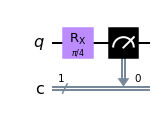

In [8]:
ini = QuantumCircuit(1, 1)
ini.rx(np.pi/4, 0)
ini.measure(0, 0)
ini.draw()

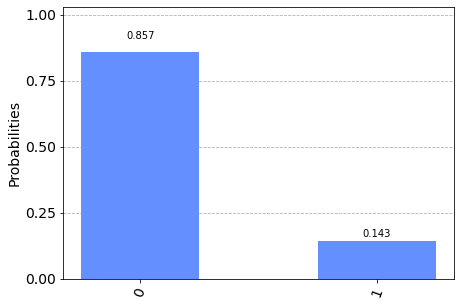

In [9]:
sim = Aer.get_backend('aer_simulator')
result = sim.run(ini).result()
counts = result.get_counts()
plot_histogram(counts)

The output state is then given by the following code. After comparison, one can easily conclude that the error correcting code works well. 

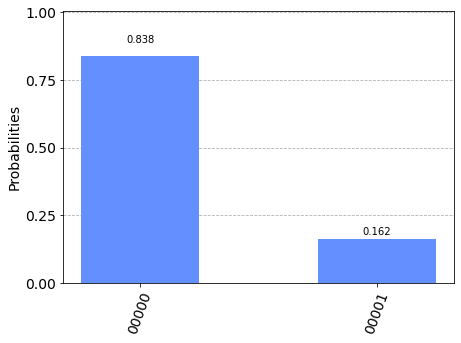

In [10]:
result = sim.run(circuit).result()
counts = result.get_counts()
plot_histogram(counts)